# CITRA DATA

### Path Data

In [18]:
import os
import cv2
import numpy as np
import pandas as pd
import random
from skimage.feature import local_binary_pattern

# Path dataset
dataset_path = "dataset/"

In [11]:
# Paths for dataset
DATASET_DIR = "dataset"
TRAIN_DIR = os.path.join(DATASET_DIR, "Train")
TEST_DIR = os.path.join(DATASET_DIR, "Test")
VAL_DIR = os.path.join(DATASET_DIR, "Validation")

# FUNGSI PROGRAM

### Load Haar Cascade

In [12]:
# Load Haar Cascade classifier untuk deteksi wajah
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

### Fungsi Klasifikasi Kelompok Umur , Ekstraksi Fitur, dan Augmentasi Gambar

In [13]:
import cv2
import numpy as np
from skimage.feature import local_binary_pattern, hog
from skimage import exposure

# Fungsi untuk mengonversi umur menjadi kategori umur
def categorize_age(age):
    if 1 <= age <= 10:
        return 0  # Anak-anak
    elif 11 <= age <= 18:
        return 1  # Remaja
    elif 19 <= age <= 59:
        return 2  # Dewasa
    return -1  # Label tidak valid

# Fungsi untuk ekstraksi fitur LBP dan HOG
def extract_lbp_hog_features(image, lbp_radius=2, lbp_points=16, 
                             hog_pixels_per_cell=(8, 8), hog_cells_per_block=(2, 2), hog_orientations=9):
    # Mengubah gambar menjadi grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Ekstraksi LBP
    lbp = local_binary_pattern(gray, lbp_points, lbp_radius, method="uniform")
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, lbp_points + 3), range=(0, lbp_points + 2))
    
    # Normalisasi histogram LBP
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-6)  # Normalisasi agar jumlah histogram = 1

    # Ekstraksi HOG
    fd, hog_image = hog(
        gray, 
        orientations=hog_orientations, 
        pixels_per_cell=hog_pixels_per_cell, 
        cells_per_block=hog_cells_per_block, 
        block_norm="L2-Hys", 
        transform_sqrt=True, 
        feature_vector=True
    )
    
    # Menormalkan gambar HOG agar bisa ditampilkan (optional)
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    # Menggabungkan fitur LBP dan HOG
    return np.hstack((lbp_hist, fd))

# Contoh penggunaan:
# Memuat gambar
image_path = 'data_mentah/'
image = cv2.imread(image_path)

# Periksa apakah gambar berhasil dimuat
if image is None:
    print(f"Error: Gambar tidak ditemukan di path: {image_path}")
else:
    # Mengekstrak fitur LBP dan HOG
    features = extract_lbp_hog_features(image)
    print("Fitur yang diekstrak:", features.shape)


Error: Gambar tidak ditemukan di path: data_mentah/


# DATA PROCESSING & EKSTRAKSI FITUR

### Read Gambar dan Menyimpannya di List

In [ ]:
# Inisialisasi list untuk menyimpan data
data = []

dataset_path = "dataset/"

# Mendapatkan daftar file gambar dalam folder dataset
image_files = [f for f in os.listdir(dataset_path) if f.endswith((".jpg", ".png"))]
image_data_by_age = {}

# Mengelompokkan gambar berdasarkan kategori umur
for image_file in image_files:
    parts = image_file.split('_')
    try:
        age = int(parts[0])  # Mengambil usia dari nama file
        age_category = categorize_age(age)
        
        if age_category != -1:
            if age_category not in image_data_by_age:
                image_data_by_age[age_category] = []
            image_data_by_age[age_category].append(image_file)
    except ValueError:
        print(f"Nama file {image_file} tidak sesuai format umur!")

# Proses gambar yang ada untuk ekstraksi fitur
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

for age_category, files in image_data_by_age.items():
    for image_file in files:
        image_path = os.path.join(dataset_path, image_file)
        
        # Baca gambar dan konversi ke grayscale
        image = cv2.imread(image_path)
        if image is None:
            continue  # Skip file jika gambar tidak dapat dibaca
        
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Ubah ke grayscale untuk LBP
        
        # Deteksi wajah
        faces = face_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

        # Jika wajah terdeteksi, crop wajah dan simpan
        if len(faces) > 0:
            for (x, y, w, h) in faces:
                # Crop wajah
                face_image = gray_image[y:y+h, x:x+w]
                face_image = cv2.resize(face_image, (256, 256))  # Resize wajah agar konsisten
                
                # Ekstraksi fitur LBP dan HOG
                features = extract_lbp_hog_features(face_image)
                
                # Menggabungkan label umur dan fitur LBP-HOG ke dalam list data
                data.append([age_category] + features.tolist())

# Jika data ada, tampilkan beberapa hasil
if data:
    print(f"Jumlah data yang berhasil diproses: {len(data)}")
else:
    print("Tidak ada data yang berhasil diproses.")

Tidak ada data yang berhasil diproses.


### Menyimpan Data Gambar ke File CSV

In [15]:
# Konversi ke DataFrame Pandas dan simpan ke CSV
df = pd.DataFrame(data, columns=['age_category'] + [f'pixel_{i}' for i in range(len(lbp_features))])
df.to_csv("df_sampled.csv", index=False)

NameError: name 'lbp_features' is not defined

# DATA CLEANING

### Read Data CSV

In [ ]:
# Membaca data dari CSV
df = pd.read_csv("df_sampled.csv")
print(df.head())

   age_category   pixel_0   pixel_1   pixel_2   pixel_3   pixel_4   pixel_5  \
0             2  0.014923  0.010956  0.013580  0.020996  0.022141  0.036484   
1             2  0.006012  0.005386  0.008789  0.015045  0.017365  0.029877   
2             2  0.013046  0.008926  0.014648  0.019180  0.020386  0.033203   
3             2  0.012726  0.009689  0.013809  0.017944  0.018997  0.037750   
4             2  0.009262  0.008698  0.010132  0.016251  0.019974  0.034317   

    pixel_6   pixel_7   pixel_8   pixel_9  pixel_10  pixel_11  pixel_12  \
0  0.057861  0.133835  0.209763  0.162720  0.072601  0.049622  0.031128   
1  0.053024  0.143723  0.255569  0.208694  0.071793  0.051544  0.026215   
2  0.055893  0.125168  0.202744  0.170639  0.064774  0.059372  0.029968   
3  0.057602  0.126038  0.172119  0.166275  0.075287  0.068192  0.033752   
4  0.060394  0.149597  0.261627  0.174118  0.068604  0.043777  0.025558   

   pixel_13  pixel_14  pixel_15  pixel_16  pixel_17  
0  0.024506  0.01683

### Cek Informasi Data

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 335 entries, 0 to 334
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age_category  335 non-null    int64  
 1   pixel_0       335 non-null    float64
 2   pixel_1       335 non-null    float64
 3   pixel_2       335 non-null    float64
 4   pixel_3       335 non-null    float64
 5   pixel_4       335 non-null    float64
 6   pixel_5       335 non-null    float64
 7   pixel_6       335 non-null    float64
 8   pixel_7       335 non-null    float64
 9   pixel_8       335 non-null    float64
 10  pixel_9       335 non-null    float64
 11  pixel_10      335 non-null    float64
 12  pixel_11      335 non-null    float64
 13  pixel_12      335 non-null    float64
 14  pixel_13      335 non-null    float64
 15  pixel_14      335 non-null    float64
 16  pixel_15      335 non-null    float64
 17  pixel_16      335 non-null    float64
 18  pixel_17      335 non-null    

#### Analisis Statistik Deskriptif

In [ ]:
# Menampilkan statistik deskriptif dari dataset
df.describe(include="all")

,age_category,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,pixel_10,pixel_11,pixel_12,pixel_13,pixel_14,pixel_15,pixel_16,pixel_17
count,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000
mean,0.979104,0.022037,0.015885,0.017142,0.019646,0.020461,0.032761,0.050757,0.112496,0.183718,0.143963,0.061749,0.048420,0.028652,0.023976,0.021523,0.015844,0.053457,0.127512
std,0.809476,0.016315,0.010214,0.007234,0.006022,0.005553,0.005180,0.008250,0.027263,0.061729,0.045097,0.012425,0.013636,0.005159,0.005479,0.006933,0.009398,0.027478,0.084745
min,0.000000,0.000076,0.000183,0.001099,0.000977,0.002151,0.012589,0.014389,0.022614,0.033752,0.028778,0.018295,0.015259,0.012009,0.004822,0.005676,0.002533,0.014374,0.003311
25%,0.000000,0.010117,0.008858,0.012093,0.016174,0.017639,0.029686,0.045586,0.094810,0.138794,0.107780,0.054276,0.039764,0.025665,0.020470,0.016212,0.009117,0.034851,0.067749
50%,1.000000,0.016724,0.012283,0.016022,0.019547,0.020477,0.032913,0.052109,0.119171,0.187836,0.153152,0.063339,0.047241,0.028488,0.024185,0.020523,0.011826,0.046143,0.096695
75%,2.000000,0.032532,0.023399,0.022415,0.023880,0.024361,0.036385,0.056953,0.132996,0.225967,0.176163,0.070053,0.054253,0.031227,0.027588,0.026794,0.022118,0.063622,0.182587
max,2.000000,0.083649,0.060837,0.034576,0.033157,0.035736,0.047272,0.066666,0.164230,0.360779,0.260193,0.102402,0.110199,0.055496,0.037338,0.036133,0.054962,0.177582,0.479401


In [ ]:
# Memeriksa jumlah nilai yang hilang di setiap kolom
missing_values = df.isnull().sum()
missing_values[missing_values > 0]

Series([], dtype: int64)

#### Cek Data Duplikat

In [ ]:
# Menghapus baris duplikat
df = df.drop_duplicates()

# Memeriksa apakah ada duplikat
print(f"Jumlah data setelah menghapus duplikat: {df.shape[0]}")

Jumlah data setelah menghapus duplikat: 335


#### Memeriksa Konsistensi Kategori Usia

In [ ]:
# Memeriksa distribusi kategori usia
print(df['age_category'].value_counts())

age_category
1    116
0    113
2    106
Name: count, dtype: int64


# DATA SPLITTING

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Memisahkan fitur dan target
X = df.drop(columns=['age_category'])
y = df['age_category']

# Menggunakan SMOTE untuk menyeimbangkan kategori
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split data yang telah diseimbangkan
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.1, random_state=42)

# PELATIHAN MODEL (RANDOM FOREST)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Inisialisasi model Random Forest dengan parameter awal
model = RandomForestClassifier(n_estimators=120, random_state=42, class_weight='balanced')

# Melatih model
model.fit(X_train, y_train)

# Evaluasi model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Akurasi Model Random Forest:", accuracy * 100, "%")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Akurasi Model Random Forest: 48.57142857142857 %

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.80      0.70        10
           1       0.67      0.38      0.48        16
           2       0.23      0.33      0.27         9

    accuracy                           0.49        35
   macro avg       0.50      0.50      0.48        35
weighted avg       0.54      0.49      0.49        35



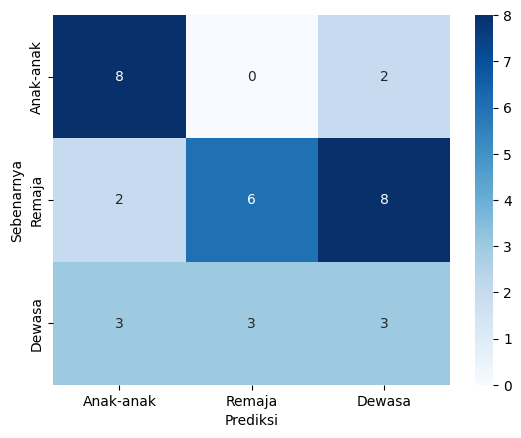

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Anak-anak', 'Remaja', 'Dewasa'], yticklabels=['Anak-anak', 'Remaja', 'Dewasa'])
plt.xlabel('Prediksi')
plt.ylabel('Sebenarnya')
plt.show()

In [ ]:
import joblib

# Menyimpan model
joblib.dump(model, "famscreen_model.pkl")

['famscreen_model.pkl']

In [ ]:
# Memuat model Random Forest yang telah disimpan
model = joblib.load('famscreen_model.pkl')
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

# PENGUJIAN MENGGUNAKAN INPUTAN GAMBAR DARI APLIKASI

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Fungsi untuk mengubah angka prediksi menjadi kategori usia (label teks)
def age_category_to_label(age_category):
    if age_category == 0:
        return "Anak-anak"
    elif age_category == 1:
        return "Remaja"
    elif age_category == 2:
        return "Dewasa"
    return "Tidak Valid"

# Fungsi untuk mendeteksi wajah dan ekstraksi fitur LBP dari gambar baru
def detect_and_predict(image_path, model, face_cascade, radius=2, n_points=16):
    # Membaca gambar dan konversi ke grayscale
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Deteksi wajah dalam gambar
    faces = face_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # Jika wajah terdeteksi
    if len(faces) > 0:
        for (x, y, w, h) in faces:
            # Crop wajah
            face_image = gray_image[y:y+h, x:x+w]
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            face_image_resized = cv2.resize(face_image, (256, 256))

            # Ekstraksi fitur LBP dari wajah yang sudah diaugmentasi
            lbp_features = extract_lbp_features(face_image_resized, radius=radius, n_points=n_points)

            # Prediksi menggunakan model Random Forest
            prediction = model.predict([lbp_features])  # Model menerima array 2D, jadi fitur LBP harus dalam list
            predicted_age_category = prediction[0]
            
            # Mengonversi angka prediksi menjadi kategori usia (label teks)
            predicted_age_label = age_category_to_label(predicted_age_category)

            # Visualisasi hasil
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            plt.title(f'Prediksi Umur: {predicted_age_label}')
            plt.axis('off')
            plt.show()

            return predicted_age_category, predicted_age_label
    else:
        print("Tidak ada wajah yang terdeteksi dalam gambar.")
        return None, None

# Contoh penggunaan deteksi dengan inputan gambar baru
image_path = "D:\\Belajar Machine Learning\\famscreen_ml\\images\\imageFile_anak.jpg"  
detected_age_category, predicted_age_label = detect_and_predict(image_path, model, face_cascade)

if detected_age_category is not None:
    print(f"Kategori Umur Prediksi: {predicted_age_label}")

[ WARN:0@3292.224] global loadsave.cpp:241 findDecoder imread_('D:\Belajar Machine Learning\famscreen_ml\images\imageFile_anak.jpg'): can't open/read file: check file path/integrity


error: OpenCV(4.10.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'
